In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister ,transpile
from qiskit_aer import AerSimulator
import numpy as np
from numpy import pi
from qiskit.quantum_info import Pauli

The Z gate is definied as 
$$
   Z= \begin{bmatrix}
    1&0\\
    0&-1\\
    \end{bmatrix}
$$
Thus if qubit is measured is state $\ket{0}$ the corresponding eigenvalue is $1$, if it is measured in the state $\ket{1}$ the eigenvalue is $-1$.


For the rest of this sheet i assume that the operator $g_2$ is a Pauli String, i.e, $g_2=IXZZX = I_5 X_4 Z_3 Z_2 X_1$, where the subscript corresponds to the quibt the gate is applied on. The Pauli class of qiskit is used to make the handling a little bit easier.

In [2]:
pauli_string="IXZZX"

The circuit will return $x$, sucht that $(-1)^x$ is the eigenvalue of the operator.

In [3]:
def f(x):
    return np.complex64(-1)**(x)

This is the  function will construct $g_2$:

In [4]:
def pauli_measurement(circuit, pauli, qr,anchilla, ):

    num_qubits = pauli.num_qubits
    for qubit_idx in range(num_qubits):
        if pauli[qubit_idx] == Pauli('I'):
            continue
        if pauli.x[qubit_idx]:
            if pauli.z[qubit_idx]:
                # Measure Y
                circuit.rx(pi/2,qubit_idx)
            else:
                # Measure X
                circuit.h(qr[qubit_idx]) 
        circuit.cx(qubit_idx,anchilla)

    return circuit

In [5]:
qr = QuantumRegister(5,'x')
qr_anchil = QuantumRegister(1,'a')
cr = ClassicalRegister(1)
sim = AerSimulator(method='statevector')

Below is the circuit to measure $g_2$

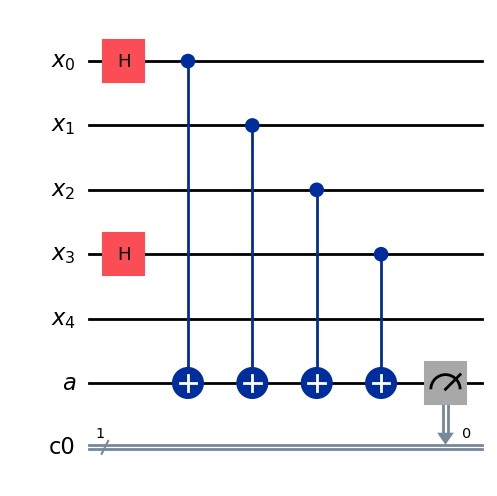

In [6]:
qc = QuantumCircuit(qr,qr_anchil,cr)
pauli_measurement(qc, Pauli(pauli_string), qr,qr_anchil   )
qc.measure(qc.qubits[-1],cr)
qc.draw('mpl')

In order to show that the circuit realy works, I calculate the output for every eigenvoector of the operator $g_2$ and compare expected and circuit output.

To construct the eigenvectors numpy is used:

In [7]:
operator = Pauli(pauli_string).to_matrix()

In [8]:
evs,evec = np.linalg.eig(operator)

Below the circuit is tested, when it runs without AssertionError, all conditions are fullfilled and the circuit works as expected. Due to numericall errors `np.isclose` is uesd instead of `==`.

In [9]:
i=0
for vec,ev in zip(evec.T,evs):
    qc = QuantumCircuit(qr,qr_anchil,cr)
    qc.initialize(vec, qr)
    pauli_measurement(qc, Pauli(pauli_string), qr,qr_anchil   )
    qc.measure(qr_anchil,cr)
    counts = sim.run(transpile(qc, sim),shots=1000).result().get_counts(0)
    assert len(list(counts.keys())) ==1
    assert np.isclose(f(int(list(counts.keys())[0])), (ev)), f"@{i}: qc={f(int(list(counts.keys())[0]))}, ev = {ev} "
    i+=1

**6)** The Operator $\hat{\mathcal{O}}$ which maps an eigenstate with eigenvalue +1 to an eigenstate with eigenvalue -1 and vice versa, has to anticommute with $g_2$.
$$
g_2\ket{\lambda_\pm}= \pm \ket{\lambda_\pm}\\
g_2 \hat{\mathcal{O}}\ket{\lambda_\pm} = -\hat{\mathcal{O}} g_2\ket{\lambda_\pm} =\mp \hat{\mathcal{O}} \ket{\lambda_\pm} = \mp\ket{\lambda_\mp}

$$

One suitabble choice for $\hat{\mathcal{O}}$ is 

In [10]:
O = Pauli("IXZXX")

To check if it really anticommutes, I use qiskit:

In [11]:
Pauli(pauli_string).anticommutes(O)

np.True_

To check if the property holds for every Eigenstate a loop as above is used. First a eigenstate with known eigenvalue is initialized, than $\hat{\mathcal{O}}$ is applied, finally $g_2$ is measured

In [12]:
i =0
for vec,ev in zip(evec.T,evs):
    qc = QuantumCircuit(qr,qr_anchil,cr)
    qc.initialize(vec, qr)
    qc.append(O.to_instruction(),qr)
    pauli_measurement(qc, Pauli(pauli_string), qr,qr_anchil   )
    qc.measure(qr_anchil,cr)
    counts = sim.run(transpile(qc, sim),shots=1000).result().get_counts(0)
    assert len(list(counts.keys())) ==1
    assert np.isclose(f(int(list(counts.keys())[0])), -1* (ev)), f"@{i}: qc={f(int(list(counts.keys())[0]))}, ev = {ev} "
    i+=1

Note the additonal -1* in the last `assert`.